In [8]:
import torch
import matplotlib.pyplot as plt
import networks
from visualize_utils import *
import utils
from depth_anything import dpt
import cv2
import torch
import layers

## 测试Decompose

In [13]:
encoder = networks.ResnetEncoder(18, False).to(torch.device("cuda"))
decoder = networks.DecomposeDecoder(encoder.num_ch_enc).to(torch.device("cuda"))
image_loader = ImageLoader(1, 1)
images = image_loader.batch([1,2,3])

/home/zhouy/miniconda3/envs/da2/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/zhouy/miniconda3/envs/da2/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [14]:
feats = encoder(images)
outputs = decoder(feats, images)

In [15]:
T = [outputs["A"].unsqueeze(2), outputs["A"].unsqueeze(2)]
h = torch.cat(T, dim=2)
h.shape

torch.Size([3, 3, 2, 256, 320])

## 测试DPTV2

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}

encoder = 'vits' # or 'vits', 'vitb', 'vitg'

model = networks.depth.Depth(**model_configs[encoder], device=DEVICE)
model.load_state_dict(torch.load(f'checkpoints/depth_anything_v2_{encoder}.pth', map_location='cpu'))
model = model.to(DEVICE)
image_loader = ImageLoader(1, 1)
images = image_loader.batch([1,2,3])

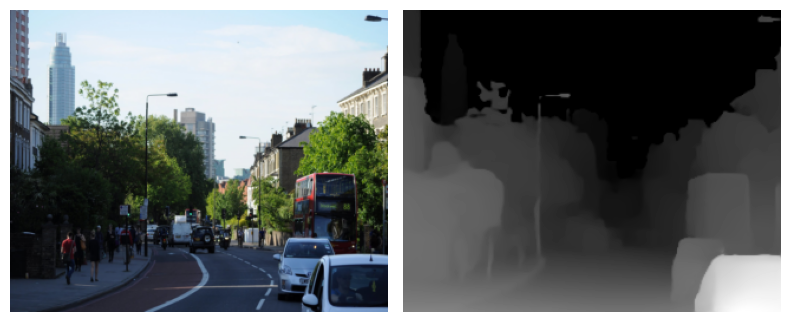

In [4]:
image_path = get_image_path(5, 3, 1)
image_path = './demo01.jpg'
image = load_image(image_path, 'cuda')
depth = model(image)
plot_images([image, depth])


In [5]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=10,  # 低秩维度，平衡效率和性能
    lora_alpha=20,  # 缩放因子，通常为 2*r
    target_modules=["qkv"],  # 针对 ViT 层
    lora_dropout=0.05,  # dropout 防止过拟合
    bias="none",  # 不调整偏置
    task_type=None  # 自定义任务类型
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

/home/zhouy/miniconda3/envs/da2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


trainable params: 184,320 || all params: 24,969,409 || trainable%: 0.7382


## 测试DRM

In [ ]:
def extract_samples(suppressed_seq, M_seq, num_pos=128, num_neg=128, T=5):
    B, T, C, H, W = suppressed_seq.shape
    flat_feat = suppressed_seq.view(B, T, C, -1)  # [B, T, C, HW]
    flat_M = M_seq.view(B, T, 1, -1)
    mid = int(T / 2)
    
    # 正样本：相邻帧 (t-1, t+1) 非反射平均 [B, C]
    non_reflect_mask = (flat_M[:, mid-1:mid+1] < 0.5).squeeze(2).float()  # 中间帧相邻
    pos_indices = torch.multinomial(non_reflect_mask.view(B, -1), num_pos, replacement=True)
    pos_feat = flat_feat[:, mid-1:mid+1].view(B, (T-2)*C, -1)  # 时空展平
    pos = torch.gather(pos_feat, 2, pos_indices.unsqueeze(1).expand(-1, (T-2)*C, -1)).mean([1,2])
    
    # 负样本：当前序列反射平均 [B, C]
    reflect_mask = (flat_M > 0.5).squeeze(2).float().view(B, -1)
    neg_indices = torch.multinomial(reflect_mask, num_neg, replacement=True)
    neg_feat = flat_feat.view(B, T*C, -1)
    neg = torch.gather(neg_feat, 2, neg_indices.unsqueeze(1).expand(-1, T*C, -1)).mean([1,2])
    
    return pos, neg

In [2]:
encoder = networks.ResnetEncoder(18, False).to(torch.device("cuda"))
decoder = networks.DecomposeDecoder(encoder.num_ch_enc).to(torch.device("cuda"))
image_loader = ImageLoader(1, 1)
images = image_loader.batch([1,2,3])
feats = encoder(images)
outputs = decoder(feats, images)
drm = networks.DynamicReflectionModule().to(torch.device("cuda"))
drm_input_A = outputs["A"].unsqueeze(2).permute(2, 1, 0, 3, 4)
drm_input_M = outputs["M"].unsqueeze(2).permute(2, 1, 0, 3, 4)
drm_output = drm(drm_input_A, drm_input_M)

/home/zhouy/miniconda3/envs/da2/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/zhouy/miniconda3/envs/da2/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [11]:
import torch.nn as nn
import torch
import math
from einops import rearrange
import os

a = torch.randn(8, 3, 256, 320)
b = torch.randn(8, 3, 256, 320)
c = [a, b]
torch.stack(c, dim=1).shape

torch.Size([8, 2, 3, 256, 320])

## 测试DPTV2(transformers)

In [1]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, DepthAnythingForDepthEstimation
import torch

/home/zhouy/miniconda3/envs/da2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model = DepthAnythingForDepthEstimation.from_pretrained("checkpoints/Depth-Anything-V2-Small-hf").to('cuda')

In [ ]:
image_path = './demo01.jpg'
image = load_image(image_path, 'cuda')
depth = model(image)
depth.shape
# plot_images([image, depth])


In [4]:
torch.save(model.state_dict(), 'model.pth')

In [5]:
model_state_dict = torch.load('model.pth')
model = DepthAnythingForDepthEstimation()
model.load_state_dict(model_state_dict)

TypeError: __init__() missing 1 required positional argument: 'config'

## 其他

In [2]:
import torch.nn as nn
import torch
from visualize_utils import *
import matplotlib.pyplot as plt

2
torch.Size([1, 1, 3, 3])
